**BERT MODEL FOR Text Classification**

This model is built in PyTorch native. You can also build a model in TensorFlow.

https://towardsdatascience.com/pytorch-vs-tensorflow-for-transformer-based-nlp-applications-b851bdbf229a

https://realpython.com/pytorch-vs-tensorflow/

For more info about BERT in general, as well as some specific classes, please check the links at the begining of this notobook and the links at the beginning of the particular cells.


some useful links:

https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

https://huggingface.co/blog/bert-101

https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model



**Building steps**:

  Reading and processing the data

  Selecting the model and tokanizer and building the embedings

  Creating an input pipeline

  Defining the evaluation metrics

  Training the model

  Evaluating the model on the validation set

  Evaluating the model on the test set with different distribution


In [1]:
import os

# Set the environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:
!pip install -q transformers

In [3]:
import torch
import time
from tqdm.notebook import tqdm
import json

from transformers import AutoTokenizer
from torch.utils.data import TensorDataset

from transformers import AutoModelForSequenceClassification


In [4]:

import pandas as pd
import numpy as np
import re
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
pd.set_option("max_colwidth", None)

In [16]:
lst_dics = []
with open('drive/MyDrive/News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )

lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [17]:
df = pd.DataFrame(lst_dics)
df.head()


,category,headline,authors,link,short_description,date
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Andy McDonald,https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carrey-adam-schiff-democrats_us_5b0950e8e4b0fdb2aa53e675,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-margulies-trump-poop-bag_us_5b093ec2e4b0fdb2aa53df70,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",2018-05-26


In [18]:
df['category'].value_counts()

,count
category,
POLITICS,32739
WELLNESS,17827
ENTERTAINMENT,16058
TRAVEL,9887
STYLE & BEAUTY,9649
PARENTING,8677
HEALTHY LIVING,6694
QUEER VOICES,6314
FOOD & DRINK,6226


In [19]:
df = df[(df['category']=='POLITICS')| (df['category']=='ENTERTAINMENT') | (df['category']=='WELLNESS')]
df['category'].value_counts()

,count
category,
POLITICS,32739
WELLNESS,17827
ENTERTAINMENT,16058


In [20]:
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'ENTERTAINMENT': 0, 'POLITICS': 1, 'WELLNESS': 2}

In [21]:
df['label'] = df['category'].replace(label_dict)

In [22]:
df['text'] = df['headline'] + " " + df['short_description']

In [23]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets, stratified by labels
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,          # Indices of the dataframe
    df.label.values,          # Labels of the dataframe
    test_size=0.1,           # Size of the validation set (10%)
    random_state=42,          # Random seed for reproducibility
    stratify=df.label.values  # Ensure that class distribution is preserved in the split
)

# Initialize a new column 'data_type' in the dataframe and set all values to 'not_set'
df['data_type'] = ['not_set'] * df.shape[0]

# Assign 'train' label to indices in the training set and 'val' label to indices in the validation set
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

# Group by label and data_type to check the distribution of classes in the training and validation sets
df.groupby(['label', 'data_type']).size()


label  data_type
0      train        14452
       val           1606
1      train        29465
       val           3274
2      train        16044
       val           1783
dtype: int64

https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification

In [6]:
### select the model and tokanizer


model_name = "bert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import AutoTokenizer, AutoConfig

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, max_len=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [25]:
### make embedings for training and validation data set

model_max_len=512

# Tokenize and encode textual data for the training set
encoded_data_train = tokenizer.batch_encode_plus(
    # List of candidate pairs for training
    df[df.data_type=='train'].text.to_list(),
    add_special_tokens=True,         # Add special tokens like [CLS] and [SEP] (begining and end of the sentence)
    return_attention_mask=True,     # Return attention masks
    pad_to_max_length=True,         # Pad sequences to the same length
    max_length=512,                 # Maximum sequence length
    return_tensors='pt'             # Return PyTorch tensors
).to(device)

# Tokenize and encode textual data for the validation set
encoded_data_val = tokenizer.batch_encode_plus(
    # List of candidate pairs for validation
    df[df.data_type=='val'].text.to_list(),
    add_special_tokens=True,         # Add special tokens like [CLS] and [SEP] (begining and end of the sentence)
    return_attention_mask=True,     # Return attention masks
    pad_to_max_length=True,         # Pad sequences to the same length
    max_length=512,                 # Maximum sequence length
    return_tensors='pt'             # Return PyTorch tensors
).to(device)

# Extract input IDs, attention masks, and labels for the training set
input_ids_train = encoded_data_train['input_ids']       # Input IDs (integer representations of tokens in the input text)
attention_masks_train = encoded_data_train['attention_mask']   # Attention masks
labels_train = torch.tensor(df[df.data_type=='train'].label.values)  # Labels as PyTorch tensors

# Extract input IDs, attention masks, and labels for the validation set
input_ids_val = encoded_data_val['input_ids']           # Input IDs (integer representations of tokens in the input text)
attention_masks_val = encoded_data_val['attention_mask']       # Attention masks
labels_val = torch.tensor(df[df.data_type=='val'].label.values)  # Labels as PyTorch tensors

# Create PyTorch datasets for training and validation
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


https://pytorch.org/docs/stable/data.html

https://www.scottcondron.com/jupyter/visualisation/audio/2020/12/02/dataloaders-samplers-collate.html

In [26]:
### create the pipeline

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html

https://huggingface.co/docs/transformers/main_classes/optimizer_schedules

https://www.kaggle.com/code/rhtsingh/guide-to-huggingface-schedulers-differential-lrs/notebook


In [23]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-6,
                  eps=1e-8)

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
### define the evaluation step

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [26]:
df_train = df[df['data_type']=='train']

In [36]:

# Train the model
for epoch in range(1, epochs + 1):

    model.train()  # Set the model to training mode

    loss_train_total = 0
    batch_count = 0

    # Suppress detailed progress bar output
    progress_bar = tqdm(dataloader_train, desc=f'Epoch {epoch}', leave=True, disable=False)
    for batch_idx, batch in enumerate(progress_bar):

        model.zero_grad()  # Reset gradients

        batch = tuple(b.to(device) for b in batch)  # Move batch to device

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)  # Forward pass

        loss = outputs[0]
        logits = outputs[1]
        num_classes = 3

        # Calculate class weights to address class imbalance
        num_class_0_samples = df_train[df_train['label'] == 0].shape[0]
        num_class_1_samples = df_train[df_train['label'] == 1].shape[0]
        num_class_2_samples = df_train[df_train['label'] == 2].shape[0]

        weights = [1 / math.sqrt(num_class_0_samples),
                   1 / math.sqrt(num_class_1_samples),
                   1 / math.sqrt(num_class_2_samples)]
        weight_tensor = torch.tensor(weights, dtype=torch.float, device=device)

        criterion = torch.nn.CrossEntropyLoss(weight=weight_tensor)
        loss_train_total += criterion(logits, inputs['labels'])
        loss.backward()  # Backward pass

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping

        optimizer.step()  # Update weights
        scheduler.step()  # Update learning rate scheduler


        progress_bar.set_postfix({'training_loss': f'{loss.item() / len(batch):.3f}'})

        batch_count += 1

    # Save the model state
    torch.save(model.state_dict(), f'drive/MyDrive/news_{epoch}.model')

    # Output epoch results
    print(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / batch_count
    print(f'Training loss: {loss_train_avg:.4f}')

    # Validation phase (assuming you have a validation loop)
    model.eval()  # Set the model to evaluation mode
    val_loss, predictions, true_vals = evaluate(dataloader_validation)  # Evaluate model on validation data


    print(f'Validation loss: {val_loss:.4f}')


Epoch 1: 100%|██████████| 19987/19987 [42:11<00:00,  7.90it/s, training_loss=0.000]



Epoch 1
Training loss: 0.1678
Validation loss: 0.2133


Epoch 2: 100%|██████████| 19987/19987 [41:40<00:00,  7.99it/s, training_loss=0.000]



Epoch 2
Training loss: 0.1662
Validation loss: 0.2133


Epoch 3: 100%|██████████| 19987/19987 [41:29<00:00,  8.03it/s, training_loss=0.000]



Epoch 3
Training loss: 0.1654
Validation loss: 0.2133


In [9]:
 ### put the model to device

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
### load the model that was previously saved

model.load_state_dict(torch.load('drive/MyDrive/news_3.model'))



<ipython-input-10-825ea51c1548>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('drive/MyDrive/news_3.model'))


<All keys matched successfully>

In [27]:
### evaluate the saved model

_, predictions, true_vals = evaluate(dataloader_validation)

In [29]:
### do evaluation with sklearn classification report and confusion matrix

preds = np.argmax(predictions, axis = 1)


In [30]:
class_names = ['Entertainmant', 'Politics', 'Wellness']

In [31]:
print(classification_report(true_vals, preds, target_names=class_names))

               precision    recall  f1-score   support

Entertainmant       0.95      0.93      0.94      1606
     Politics       0.96      0.97      0.96      3274
     Wellness       0.96      0.97      0.97      1783

     accuracy                           0.96      6663
    macro avg       0.96      0.96      0.96      6663
 weighted avg       0.96      0.96      0.96      6663



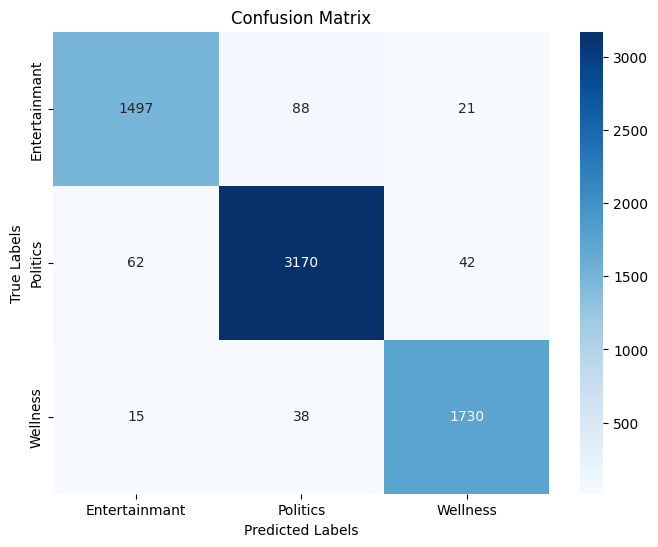

In [32]:
# Compute the confusion matrix
cm = confusion_matrix(true_vals, preds)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Entertainmant', 'Politics', 'Wellness'],
            yticklabels=['Entertainmant', 'Politics', 'Wellness'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
